# Simple Inversion Example Using Gaussian-Process Emulator
**Gaussian-Process Emulator** from [psimpy](https://git-ce.rwth-aachen.de/mbd/psimpy) package to solve geophysical inverse problem by determining the best model parameter from the lowest RMS error.

In [15]:
# Necessary packages
import numpy as np
import matplotlib.pyplot as plt
from psimpy.sampler import LHS
from psimpy.emulator import ScalarGaSP

**Gravity acceleration forward modeling equation for spherical object:**
$$g \space [\text{m/s}^{2}] = \frac{G. \pi. R^3. \Delta\rho. z}{(3. [x_i - x]^2 + z^2)^{3/2}}$$
$G$ = Universal gravitational constant $6.67 \times 10^{-11} \space [\text{m}^3 / \text{kg.s}^2]$

$R$ = Radius of the sphere object $[\text{m}]$

$\Delta\rho$ = Relative density difference (will be the target parameter) $[\text{kg/m}^3]$

$z$ = Location of the sphere object in vertical direction (depth) $[\text{m}]$

$x$ = Location of the sphere object in horizontal direction $[\text{m}]$

$x_i$ = Measurement point locations on the surface (`list` or `array`) $[\text{m}]$

In [16]:
def grav_fwd(R, d_rho, xi, x, z):
	G = 6.67*10**(-11)
	g_obs = (G * np.pi * (R**3) * d_rho * z) / ((3 * (xi - x)**2 + z**2)**(3/2))
	return g_obs

In [17]:
def RMSE(x1, x2):
    RMS = np.sqrt(np.sum( (x1 - x2)**2 ) / len(x1) ) * 100
    return RMS

### Parameter input and forward calculation

In [18]:
d_rho_true1 = 300 # True density value
R_object1 = 20
x_position1 = np.arange(0, 100, 1)
x_location1 = 30
z_location1 = 10

forward_true1 = grav_fwd(R_object1, d_rho_true1, x_position1, x_location1, z_location1) * 10e5 # Multiply by 10e5 to convert m/s^2 to mGal (10e-1 mm/s^2)

# Added with random noise
forward_true = forward_true1 + (np.random.randint(-100,100,len(forward_true1)) / 100000)

In [19]:
density_test = np.arange(-500, 501, 100) # Density range values to test

forward_test = [grav_fwd(R_object1, i, x_position1, x_location1, z_location1) * 10e5 for i in density_test]

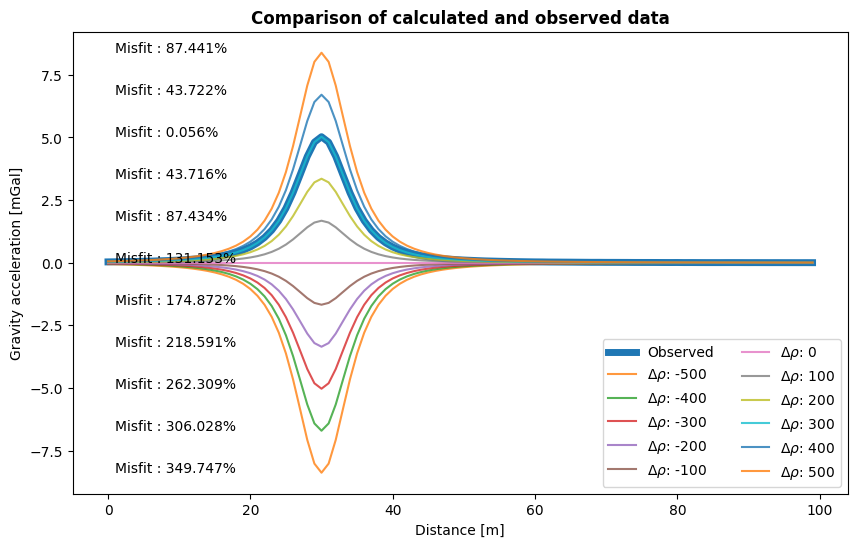

In [20]:
plt.figure(figsize=(10,6))
plt.title('Comparison of calculated and observed data', fontweight='bold')
plt.plot(x_position1, forward_true, lw = 5, label='Observed')

for i in range(len(forward_test)):
    RMS_misfit = RMSE(forward_test[i], forward_true)
    plt.plot(x_position1, forward_test[i], alpha = 0.8, label=r'$\Delta\rho$: '+str((density_test[i])))
    if np.max(forward_test[i]) - np.max(np.abs(forward_test[i])) == 0:
        plt.text(x_position1[1], np.max(forward_test[i]), 'Misfit : '+str('%.3f'%RMS_misfit)+'%')
    else:
        plt.text(x_position1[1], np.min(forward_test[i]), 'Misfit : '+str('%.3f'%RMS_misfit)+'%')

plt.xlabel('Distance [m]')
plt.ylabel('Gravity acceleration [mGal]')
plt.legend(loc='lower right', ncol=2);

## GP Emulator
### LHS Sampling
Sampling the density value to be simulated by using [Latin Hypercube Sampling (LHS)](https://mbd.pages.git-ce.rwth-aachen.de/psimpy/auto_examples/sampler/plot_latin.html#sphx-glr-auto-examples-sampler-plot-latin-py) from psimpy package.

In [21]:
ndim = 1
bounds = np.array([[-500,500]])

lhs_sampler = LHS(ndim, bounds, seed=100)
lhs_samples = lhs_sampler.sample(nsamples=5) # get 5 density values for training

In [22]:
input_density = lhs_samples.reshape(-1)

# input for further process need to be in array type
output_fwd_grav = np.array([grav_fwd(R_object1, dens, x_position1, x_location1, z_location1) * 10e5 for dens in input_density])

In [23]:
RMS_for_emulator = np.array([RMSE(output_fwd_grav[index], forward_true) for index in range(len(output_fwd_grav))])

emulator = ScalarGaSP(ndim=1)

# design = x (input or parameter), response = y (output or label)
emulator.train(design=input_density, response=RMS_for_emulator)
validation = emulator.loo_validate() # to view the validation result and comparison

x = input_density
y = RMS_for_emulator

The upper bounds of the range parameters are 233330.6 
The initial values of range parameters are 4666.611 
Start of the optimization  1  : 
The number of iterations is  7 
 The value of the  marginal posterior  function is  -17.52637 
 Optimized range parameters are 854.742 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 66.21876 
Start of the optimization  2  : 
The number of iterations is  10 
 The value of the  marginal posterior  function is  -17.52637 
 Optimized range parameters are 854.742 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 


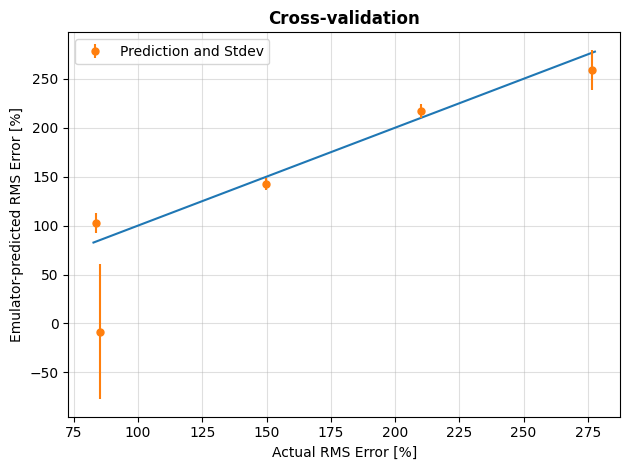

In [24]:
plt.figure()
plt.title('Cross-validation', fontweight='bold')

plt.xlabel('Actual RMS Error [%]')
plt.ylabel('Emulator-predicted RMS Error [%]')

_ = plt.plot([np.min(y)-1,np.max(y)+1], [np.min(y)-1,np.max(y)+1])
_ = plt.errorbar(y, validation[:,0], validation[:,1], fmt='.', ms=10, linestyle='', label='Prediction and Stdev')
_ = plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout();

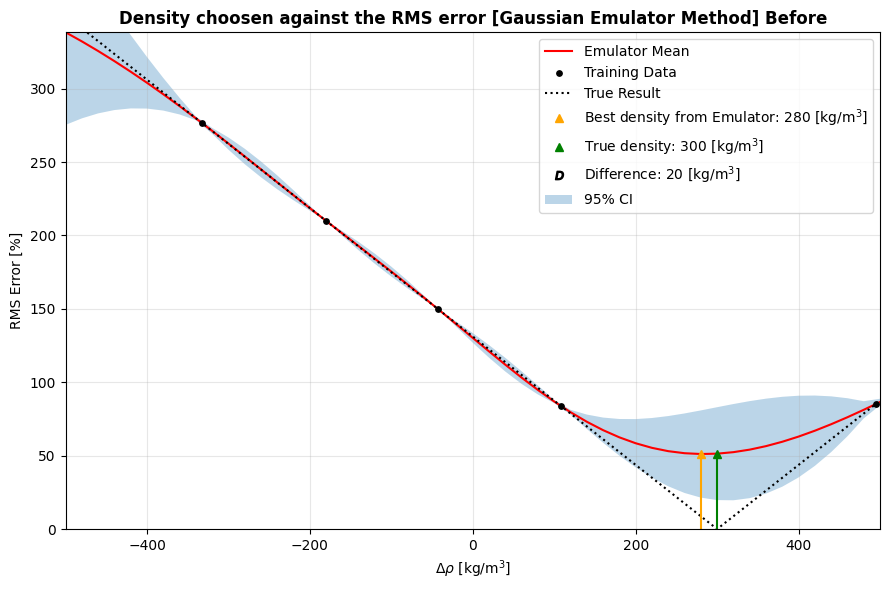

In [25]:
plt.figure(figsize=(9,6))
plt.title('Density choosen against the RMS error [Gaussian Emulator Method] Before', fontweight='bold')

testing_input = np.arange(bounds[0][0],bounds[0][1]+1,20) # density range for prediction
true_input = np.array([grav_fwd(R_object1, dens, x_position1, x_location1, z_location1) * 10e5 for dens in testing_input])
RMS_input = np.array([np.sqrt(np.sum((true_input[index] - forward_true)**2)/len(forward_true)) * 100 for index in range(len(true_input))])

predictions = emulator.predict(testing_input)

where_lowest_RMS = np.where(predictions[:,0] == np.min(predictions[:,0]))
where_best_density = testing_input[where_lowest_RMS]

plt.plot(testing_input, predictions[:, 0], 'r-', label= "Emulator Mean")
plt.scatter(x, y, s=15, c='k', label="Training Data", zorder=3)
plt.plot(testing_input, RMS_input, 'k:', zorder=2, label="True Result")

#best density from emulator
plt.vlines(where_best_density, 0, predictions[:, 0][where_lowest_RMS], color='orange')
plt.plot(where_best_density, predictions[:, 0][where_lowest_RMS], '^', color='orange', label="Best density from Emulator: "+str(where_best_density[0])+r" $[\text{kg/m}^3]$")
#best true density
plt.vlines(d_rho_true1, 0, predictions[:, 0][where_lowest_RMS], color='green')
plt.plot(d_rho_true1, predictions[:, 0][where_lowest_RMS], '^', color='green', label="True density: "+str(d_rho_true1)+r" $[\text{kg/m}^3]$")
#result difference
plt.plot([],[], marker='$D$', ls='', color='black', label='Difference: '+str(d_rho_true1 - where_best_density[0])+r" $[\text{kg/m}^3]$")

plt.fill_between(testing_input, predictions[:, 1], predictions[:, 2], alpha=0.3, label="95% CI")
plt.xlabel(r'$\Delta\rho$ $[\text{kg/m}^3]$')
plt.ylabel('RMS Error [%]')
plt.xlim(testing_input[0], testing_input[-1])
plt.ylim(0, np.max(predictions[:,0]))
_ = plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout();

## Adaptive sampling
To get a better result by updating training data in the lowest RMS Error area.

Algorithm was slightly modified from [Kim & Boukouvala, 2020](https://link.springer.com/article/10.1007/s11590-019-01428-7).

In [26]:
n_iter = 10 # maximum iteration
RMS_convergence = 0.01 # desired RMS value limit

true_input2 = np.array([grav_fwd(R_object1, dens, x_position1, x_location1, z_location1) * 10e5 for dens in testing_input])
RMS_input2 = np.array([RMSE(true_input2[index], forward_true) for index in range(len(true_input2))])

In [27]:
lhs_samples2 = list(lhs_samples.copy())

for i in range(n_iter):
    output_fwd_grav2 = np.array([grav_fwd(R_object1, dens, x_position1, x_location1, z_location1) * 10e5 for dens in lhs_samples2])
    RMS_for_emulator2 = np.array([RMSE(output_fwd_grav2[index], forward_true) for index in range(len(output_fwd_grav2))])
    
    emulator2 = ScalarGaSP(ndim=1)
    emulator2.train(design=np.array(lhs_samples2), response=RMS_for_emulator2)

    predictions2 = emulator2.predict(testing_input)

    if np.min(RMS_for_emulator2) < RMS_convergence:
        print('********\n\nConvergence has been reached at RMS:',np.min(RMS_for_emulator2))
        break
    elif i == n_iter-1:
        print('********\n\nMaximum iteration has been reached with RMS:',np.min(RMS_for_emulator2))
        break
    
    where_lowest_RMS2 = np.where(predictions2[:,0] == np.min(predictions2[:,0]))
    
    where_best_density2 = testing_input[where_lowest_RMS2]
    lhs_samples2.append(where_best_density2)

The upper bounds of the range parameters are 233330.6 
The initial values of range parameters are 4666.611 
Start of the optimization  1  : 
The number of iterations is  7 
 The value of the  marginal posterior  function is  -17.52637 
 Optimized range parameters are 854.742 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 66.21876 
Start of the optimization  2  : 
The number of iterations is  10 
 The value of the  marginal posterior  function is  -17.52637 
 Optimized range parameters are 854.742 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The upper bounds of the range parameters are 203818.4 
The initial values of range parameters are 4076.368 
Start of the optimization  1  : 
The number of iterations is  8 
 The value of the  marginal posterior  function is  -24.05199 
 Optimized range parameters are 475.4057 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 45.98525 
Star

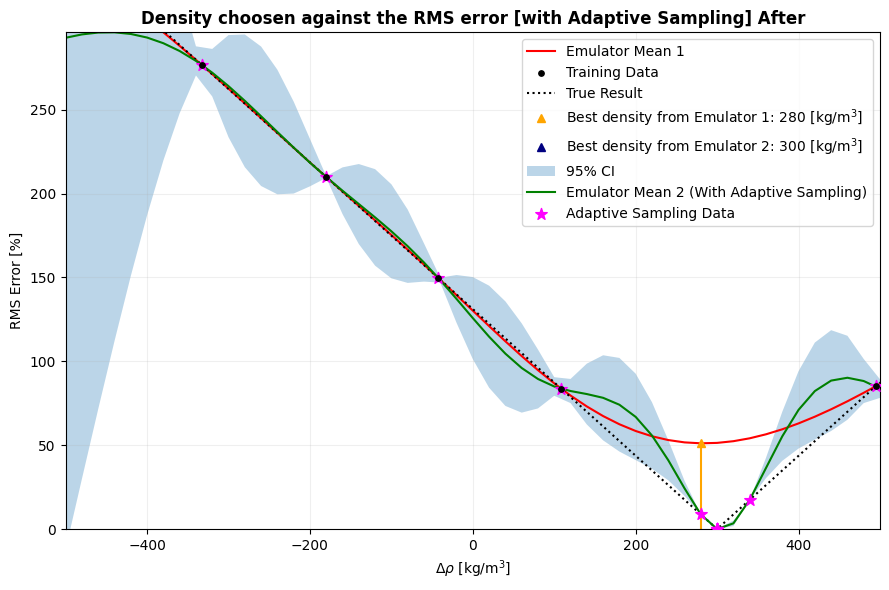

In [28]:
plt.figure(figsize=(9,6))

### Emulator 1
plt.title('Density choosen against the RMS error [with Adaptive Sampling] After', fontweight='bold')
plt.plot(testing_input, predictions[:, 0], 'r-', label= "Emulator Mean 1")
plt.scatter(x, y, s=15, c='k', label="Training Data", zorder=6)
plt.plot(testing_input, RMS_input, 'k:', zorder=2, label="True Result")

#best density from emulator 1
plt.vlines(where_best_density, 0, predictions[:, 0][where_lowest_RMS], color='orange')
plt.plot(where_best_density, predictions[:, 0][where_lowest_RMS], '^', color='orange', label="Best density from Emulator 1: "+str(where_best_density[0])+r" $[\text{kg/m}^3]$")
#best density from emulator 2
plt.vlines(lhs_samples2[-1][0], 0, predictions2[:, 0][where_lowest_RMS2], color='navy')
plt.plot(lhs_samples2[-1][0], predictions2[:, 0][where_lowest_RMS2], '^', color='navy', label="Best density from Emulator 2: "+str(lhs_samples2[-1][0])+r" $[\text{kg/m}^3]$")

plt.fill_between(testing_input, predictions2[:, 1], predictions2[:, 2], alpha=0.3, label="95% CI")
plt.xlabel(r"$\Delta\rho$ $[\text{kg/m}^3]$")
plt.ylabel('RMS Error [%]')
plt.xlim(testing_input[0], testing_input[-1])
plt.ylim(0, np.max(predictions2[:,0]))
plt.grid(alpha=0.2)

### Emulator 2
plt.plot(testing_input, predictions2[:, 0], 'g-', label= "Emulator Mean 2 (With Adaptive Sampling)")
plt.scatter(np.concatenate(lhs_samples2), RMS_for_emulator2, s=75, marker='*', c='magenta', label="Adaptive Sampling Data", zorder=3)

_ = plt.legend()
plt.tight_layout()

## 